In [81]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import pennylane as qml

# Устанавливаем двойную точность по умолчанию
torch.set_default_dtype(torch.float64)

def create_target_state_7q(number_of_odds=45):
    num_bits = int(np.ceil(np.log2(2 * number_of_odds - 1)))
    target = np.zeros(2**num_bits, dtype=np.complex128)
    for k in range(1, number_of_odds+1):
        target[2 * k - 1] = 1.0
    target /= np.sqrt(number_of_odds)
    return torch.tensor(target, dtype=torch.complex128)

def get_res_state(params, circuit, n_layers, number_of_odds = 45):
    num_qubits = int(np.ceil(np.log2(2 * number_of_odds - 1)))
    vector = circuit(params, n_layers).detach().numpy()
    state_ampl = dict()
    for i in range(0, 1 << num_qubits):
        s = f"|{i}>"
        state_ampl[s] = np.round(np.abs(vector[i]), 3)
    return state_ampl

def plot_res_state(state_ampl):
    plt.figure(figsize=(55,10))
    plt.bar(range(len(state_ampl)), state_ampl.values(), width=1, edgecolor='black', facecolor='skyblue')
    plt.hlines(1/np.sqrt(num_odds), 0, len(state_ampl), color='red', linestyles='--')
    plt.xticks(range(len(state_ampl)), state_ampl.keys(), rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'Состояния', fontsize=30)
    plt.ylabel(r'Вероятности', fontsize=30)
    plt.title(r'Итоговое распределение вероятностей для состояния $|\psi\rangle = \frac{1}{\sqrt{45}}\ \sum_{n = 0}^{45} |2k-1\rangle$', fontsize=40)
    plt.tight_layout()
    plt.show()

def print_circuit(circuit, params, n_layers):
    fig, ax = qml.draw_mpl(circuit)(params, n_layers=n_layers)
    fig.suptitle("Quantum Circuit Diagram", fontsize=40)
    plt.show()

num_odds = 45
n_qubits = int(np.ceil(np.log2(2*num_odds - 1)))

dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit6(params, n_layers=1):
    param_idx = 0
    for _ in range(n_layers):
        # RY на всех кубитах
        for w in range(n_qubits):
            qml.RY(params[param_idx], wires=w); param_idx += 1
        # All-to-all CRY
        for ctrl in range(n_qubits):
            for tgt in range(n_qubits):
                if ctrl != tgt:
                    qml.CRY(params[param_idx], wires=[ctrl, tgt]); param_idx += 1
        for w in range(n_qubits):
            qml.RY(params[param_idx], wires=w); param_idx += 1
    return qml.state()

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit14(params, n_layers=1):
    param_idx = 0
    for _ in range(n_layers):
        for w in range(n_qubits):
            qml.RY(params[param_idx], wires=w); param_idx += 1
        qml.CRY(params[param_idx], wires=[n_qubits-1, 0]); param_idx += 1
        for tgt in range(n_qubits-1, 0, -1):
                qml.CRY(params[param_idx], wires=[tgt-1, tgt]); param_idx += 1

        qml.CRY(params[param_idx], wires=[n_qubits-1, n_qubits-2]); param_idx += 1
        qml.CRY(params[param_idx], wires=[0, n_qubits-1]); param_idx += 1
        for tgt in range(1, n_qubits - 1):
                qml.CRY(params[param_idx], wires=[tgt, tgt-1]); param_idx += 1
        for w in range(n_qubits):
            qml.RY(params[param_idx], wires=w); param_idx += 1
    return qml.state()

#Потери + Фиделити
def fidelity_loss(predicted, target):
    inner = torch.vdot(target, predicted)
    fid = torch.abs(inner) ** 2
    return 1-fid, fid

# ----------------------------
# Обучение
# ----------------------------
def train_pennylane_circuit(
    n_layers=4,
    n_epochs=2000,
    lr=0.01,
    number_of_odds = 45,
    circuit = circuit6
):
    target = create_target_state_7q(number_of_odds)
    n_params = n_layers * n_qubits * (n_qubits + 1)
    params = nn.Parameter(
        torch.empty(n_params, dtype=torch.float64).uniform_(-torch.pi, torch.pi)
    )

    optimizer = torch.optim.Adam([params], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=150, factor=0.5)

    fidelities = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        state = circuit(params, n_layers=n_layers)  # complex128
        loss, fid = fidelity_loss(state, target)
        loss.backward()
        optimizer.step()
        scheduler.step(fid.item())

        fidelities.append(fid.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} | Fidelity: {fid.item():.12f}")

        if fid.item() >= 0.99999:
            print("Достигнута необходимая точность")
            break
        
    return fidelities, params

def plot_all_fidelities(fid_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Эпоха')
    plt.ylabel('Фиделити')
    plt.title('Эволюция фиделити во время обучения для различных схем')
    plt.grid(True)
    for circ in fid_circ.keys():
        plt.plot(fid_circ[circ], label=f'Схема {circ}')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

def plot_bar_num_of_pars(pars_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер схемы')
    plt.ylabel('Фиделити')
    plt.title('Гистограмма числа параметров от номера канала')
    plt.grid(True)
    for circ in pars_circ.keys():
        plt.bar(circ, len(pars_circ[circ]), label=f'Схема {circ}')
    plt.legend()
    plt.show()

## Обучаем для цепи типа 6, которую я модернизировал

Epoch    0 | Fidelity: 0.017590483409
Epoch  100 | Fidelity: 0.827294290695
Epoch  200 | Fidelity: 0.862202571133
Epoch  300 | Fidelity: 0.867515552142
Epoch  400 | Fidelity: 0.888543400309
Epoch  500 | Fidelity: 0.919977396677
Epoch  600 | Fidelity: 0.944309298587
Epoch  700 | Fidelity: 0.958141966382
Epoch  800 | Fidelity: 0.963228962443
Epoch  900 | Fidelity: 0.966031376408
Epoch 1000 | Fidelity: 0.968535088923
Epoch 1100 | Fidelity: 0.972758263507
Epoch 1200 | Fidelity: 0.983195524845
Epoch 1300 | Fidelity: 0.992024321792
Epoch 1400 | Fidelity: 0.995268618544
Epoch 1500 | Fidelity: 0.996495696207
Epoch 1600 | Fidelity: 0.997198023775
Epoch 1700 | Fidelity: 0.997778864568
Epoch 1800 | Fidelity: 0.998279156400
Epoch 1900 | Fidelity: 0.998707136690
Epoch 2000 | Fidelity: 0.999062128322
Epoch 2100 | Fidelity: 0.999342117402
Epoch 2200 | Fidelity: 0.999558181198
Epoch 2300 | Fidelity: 0.999713251362
Epoch 2400 | Fidelity: 0.999820545146
Epoch 2500 | Fidelity: 0.999890890545
Epoch 2600 |

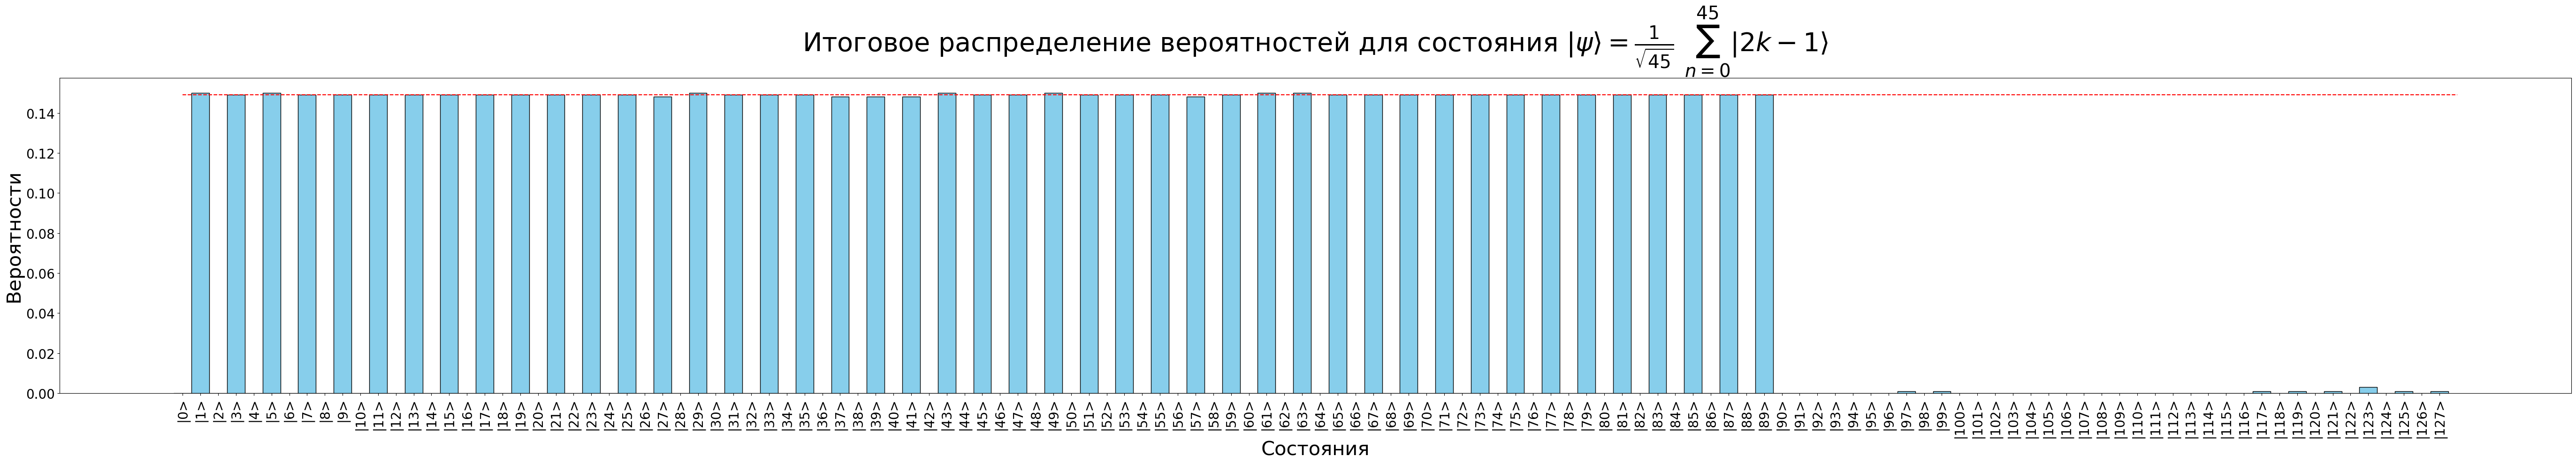

In [69]:
n_layers = 1
n_epochs = 300000

fid_circ = {}
par_circ = {}

circ = '6'

fid_circ[circ], par_circ[circ] = train_pennylane_circuit(n_layers=n_layers, n_epochs=n_epochs)
state_ampl = get_res_state(par_circ[circ], circuit=circuit6, number_of_odds=num_odds, n_layers=n_layers)
plot_res_state(state_ampl)


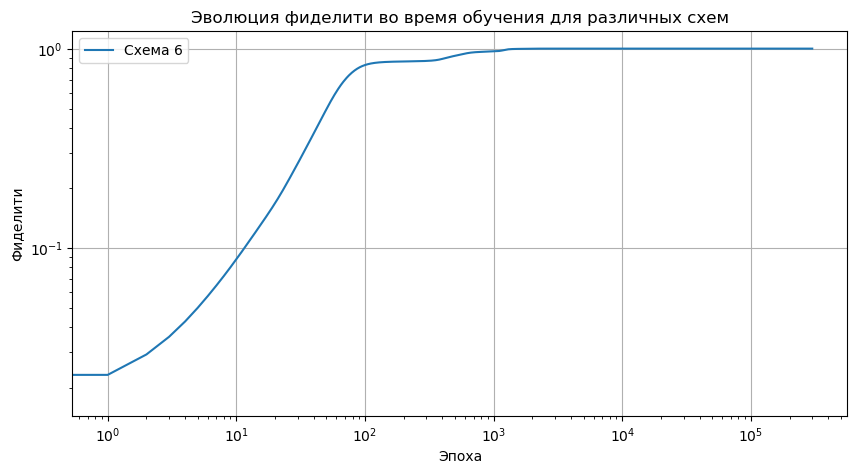

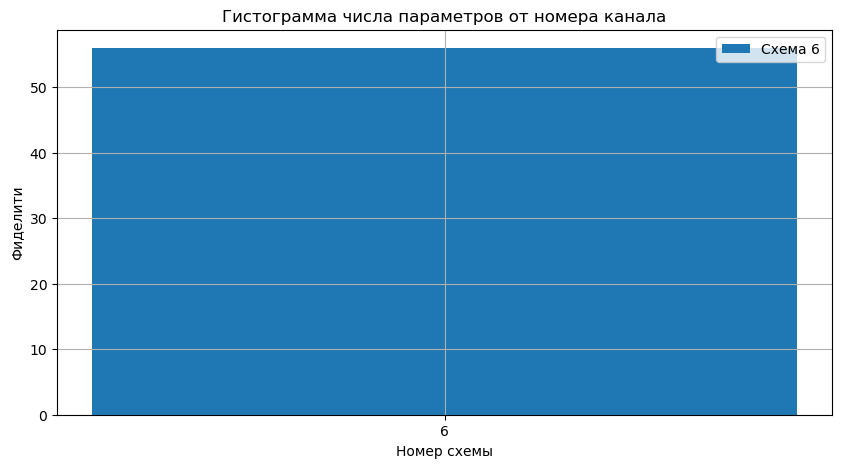

In [70]:
plot_all_fidelities(fid_circ)
plot_bar_num_of_pars(par_circ)

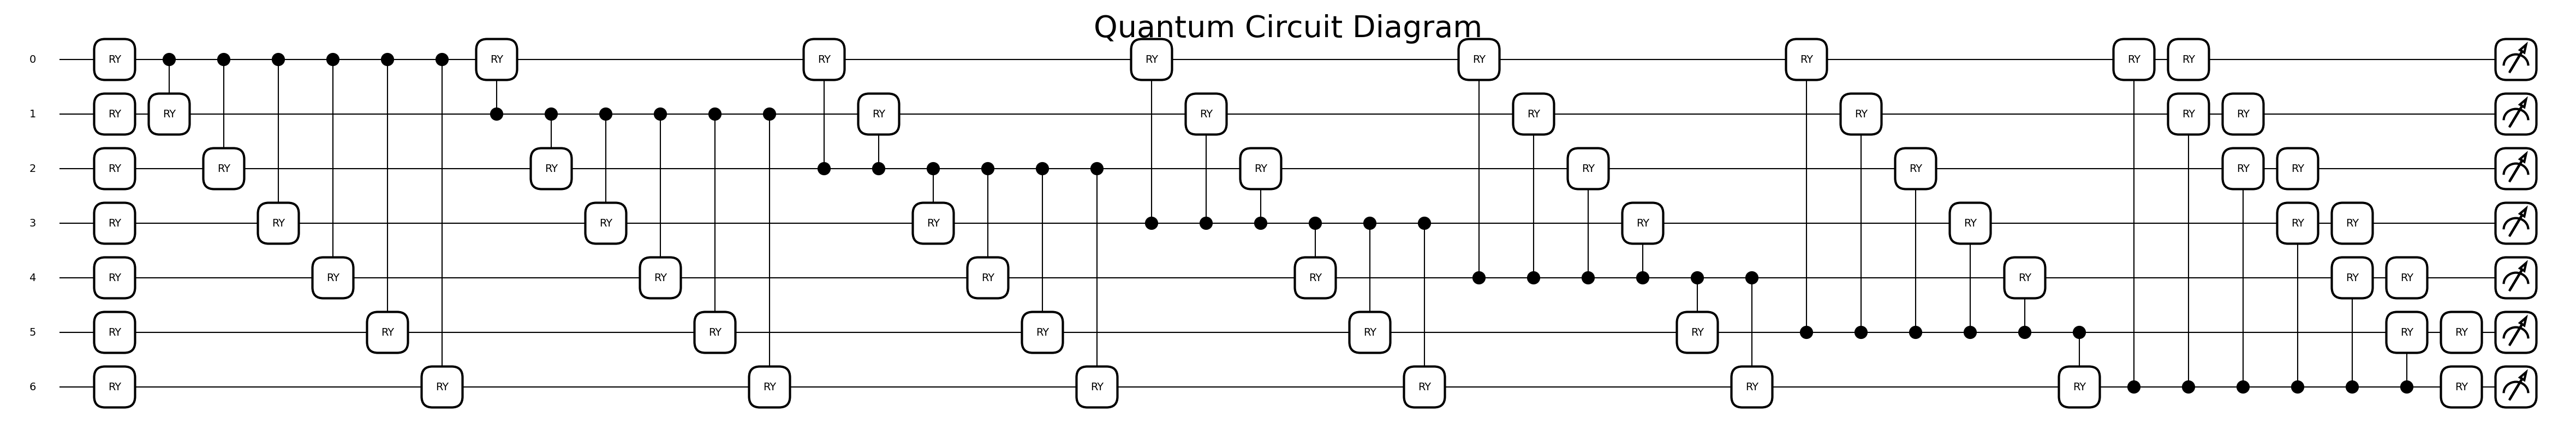

In [71]:
print_circuit(circuit6, par_circ[circ],1)

In [85]:
print(get_res_state(par_circ['6'], circuit=circuit6, number_of_odds=num_odds, n_layers=n_layers))

{'|0>': 0.0, '|1>': 0.15, '|2>': 0.0, '|3>': 0.149, '|4>': 0.0, '|5>': 0.15, '|6>': 0.0, '|7>': 0.149, '|8>': 0.0, '|9>': 0.149, '|10>': 0.0, '|11>': 0.149, '|12>': 0.0, '|13>': 0.149, '|14>': 0.0, '|15>': 0.149, '|16>': 0.0, '|17>': 0.149, '|18>': 0.0, '|19>': 0.149, '|20>': 0.0, '|21>': 0.149, '|22>': 0.0, '|23>': 0.149, '|24>': 0.0, '|25>': 0.149, '|26>': 0.0, '|27>': 0.148, '|28>': 0.0, '|29>': 0.15, '|30>': 0.0, '|31>': 0.149, '|32>': 0.0, '|33>': 0.149, '|34>': 0.0, '|35>': 0.149, '|36>': 0.0, '|37>': 0.148, '|38>': 0.0, '|39>': 0.148, '|40>': 0.0, '|41>': 0.148, '|42>': 0.0, '|43>': 0.15, '|44>': 0.0, '|45>': 0.149, '|46>': 0.0, '|47>': 0.149, '|48>': 0.0, '|49>': 0.15, '|50>': 0.0, '|51>': 0.149, '|52>': 0.0, '|53>': 0.149, '|54>': 0.0, '|55>': 0.149, '|56>': 0.0, '|57>': 0.148, '|58>': 0.0, '|59>': 0.149, '|60>': 0.0, '|61>': 0.15, '|62>': 0.0, '|63>': 0.15, '|64>': 0.0, '|65>': 0.149, '|66>': 0.0, '|67>': 0.149, '|68>': 0.0, '|69>': 0.149, '|70>': 0.0, '|71>': 0.149, '|72>': 

In [72]:
PATH = './models_par/'
torch.save(par_circ['6'], PATH + 'model_circuit_6(bob)')
par_circ['6']

Parameter containing:
tensor([ 2.1824e+00, -3.1419e+00, -2.9824e+00,  9.2245e-01,  2.9945e-02,
        -3.1159e+00,  1.8667e+00, -2.8884e+00, -3.1314e+00,  2.2136e+00,
         1.9288e+00,  3.1084e+00,  1.2748e+00,  1.3435e+00,  2.9728e+00,
         3.0653e+00,  1.9293e+00,  3.1091e+00, -5.0084e+00,  6.6338e-01,
         2.5222e+00, -3.1006e+00, -1.9446e+00,  3.1675e+00, -1.2749e+00,
        -3.8404e+00, -2.5305e+00, -1.5820e+00, -5.1004e+00,  6.3054e-04,
         6.2833e+00,  2.4454e+00,  5.5503e+00,  3.1437e+00,  1.5715e+00,
        -3.1348e+00, -1.2751e+00, -2.4220e+00,  7.5397e-01, -3.1247e+00,
        -6.3033e+00, -1.5740e+00,  1.2751e+00, -1.2953e+00,  9.6207e-01,
        -1.1600e+00,  6.1738e+00,  1.2903e+00, -3.2219e+00,  3.0845e+00,
         2.1396e+00, -1.9874e+00, -3.0187e+00, -1.2882e+00,  1.6502e+00,
        -4.8972e-04], requires_grad=True)

## Обучаем для цепи типа 14

Epoch    0 | Fidelity: 0.012574465391
Epoch  100 | Fidelity: 0.954883397015
Epoch  200 | Fidelity: 0.986265010630
Epoch  300 | Fidelity: 0.992075259050
Epoch  400 | Fidelity: 0.994296334735
Epoch  500 | Fidelity: 0.995572714121
Epoch  600 | Fidelity: 0.996590221236
Epoch  700 | Fidelity: 0.997495702594
Epoch  800 | Fidelity: 0.998229247207
Epoch  900 | Fidelity: 0.998769013237
Epoch 1000 | Fidelity: 0.999092422511
Epoch 1100 | Fidelity: 0.999287454071
Epoch 1200 | Fidelity: 0.999419925692
Epoch 1300 | Fidelity: 0.999513855271
Epoch 1400 | Fidelity: 0.999585888787
Epoch 1500 | Fidelity: 0.999641943216
Epoch 1600 | Fidelity: 0.999672654901
Epoch 1700 | Fidelity: 0.999692733777
Epoch 1800 | Fidelity: 0.999707654277
Epoch 1900 | Fidelity: 0.999716377427
Epoch 2000 | Fidelity: 0.999721289868
Epoch 2100 | Fidelity: 0.999724892570
Epoch 2200 | Fidelity: 0.999727142839
Epoch 2300 | Fidelity: 0.999728493153
Epoch 2400 | Fidelity: 0.999729507395
Epoch 2500 | Fidelity: 0.999730145687
Epoch 2600 |

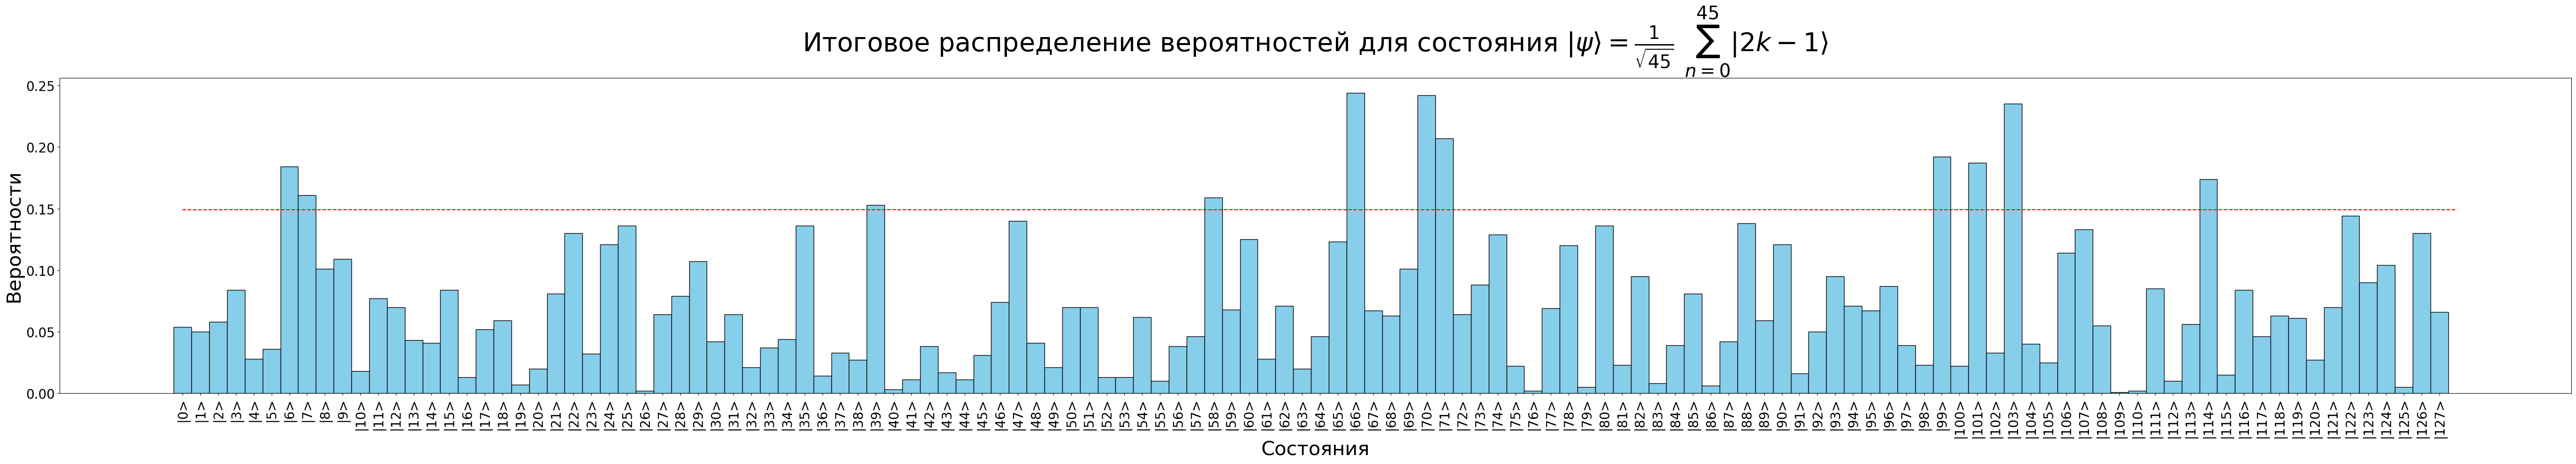

In [73]:
circ = '14'

fid_circ[circ], par_circ[circ] = train_pennylane_circuit(n_layers=n_layers*5, n_epochs=n_epochs, circuit=circuit14)

неправильно сверху функцию написал, переписал потом нижнюю картинку получил

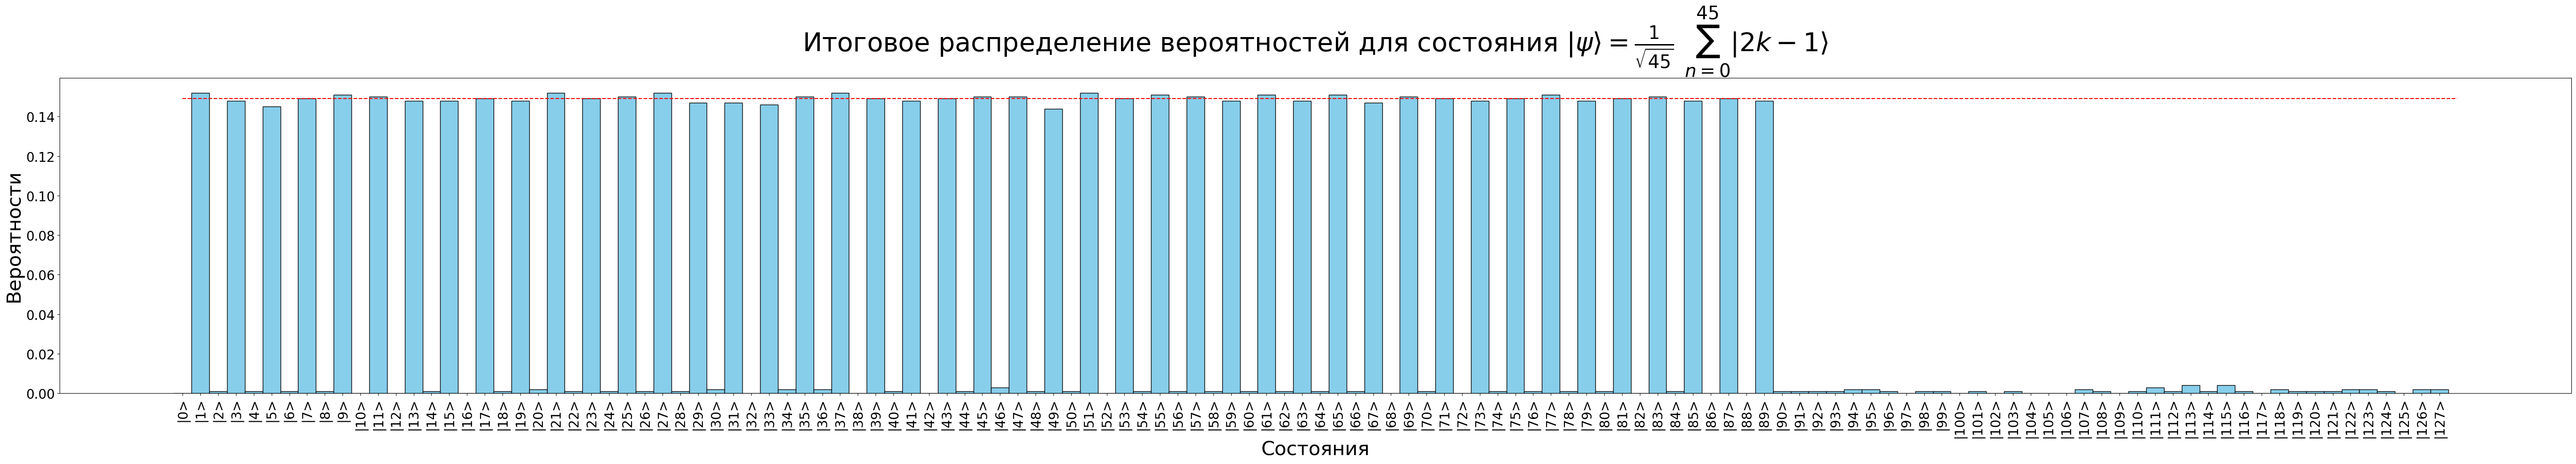

{'|0>': 0.0, '|1>': 0.152, '|2>': 0.001, '|3>': 0.148, '|4>': 0.001, '|5>': 0.145, '|6>': 0.001, '|7>': 0.149, '|8>': 0.001, '|9>': 0.151, '|10>': 0.0, '|11>': 0.15, '|12>': 0.0, '|13>': 0.148, '|14>': 0.001, '|15>': 0.148, '|16>': 0.0, '|17>': 0.149, '|18>': 0.001, '|19>': 0.148, '|20>': 0.002, '|21>': 0.152, '|22>': 0.001, '|23>': 0.149, '|24>': 0.001, '|25>': 0.15, '|26>': 0.001, '|27>': 0.152, '|28>': 0.001, '|29>': 0.147, '|30>': 0.002, '|31>': 0.147, '|32>': 0.0, '|33>': 0.146, '|34>': 0.002, '|35>': 0.15, '|36>': 0.002, '|37>': 0.152, '|38>': 0.0, '|39>': 0.149, '|40>': 0.001, '|41>': 0.148, '|42>': 0.0, '|43>': 0.149, '|44>': 0.001, '|45>': 0.15, '|46>': 0.003, '|47>': 0.15, '|48>': 0.001, '|49>': 0.144, '|50>': 0.001, '|51>': 0.152, '|52>': 0.0, '|53>': 0.149, '|54>': 0.001, '|55>': 0.151, '|56>': 0.001, '|57>': 0.15, '|58>': 0.001, '|59>': 0.148, '|60>': 0.001, '|61>': 0.151, '|62>': 0.001, '|63>': 0.148, '|64>': 0.001, '|65>': 0.151, '|66>': 0.001, '|67>': 0.147, '|68>': 0.0

In [86]:
state_ampl = get_res_state(par_circ['14'], circuit=circuit14, number_of_odds=num_odds, n_layers=n_layers*5)
plot_res_state(state_ampl)
print(state_ampl)

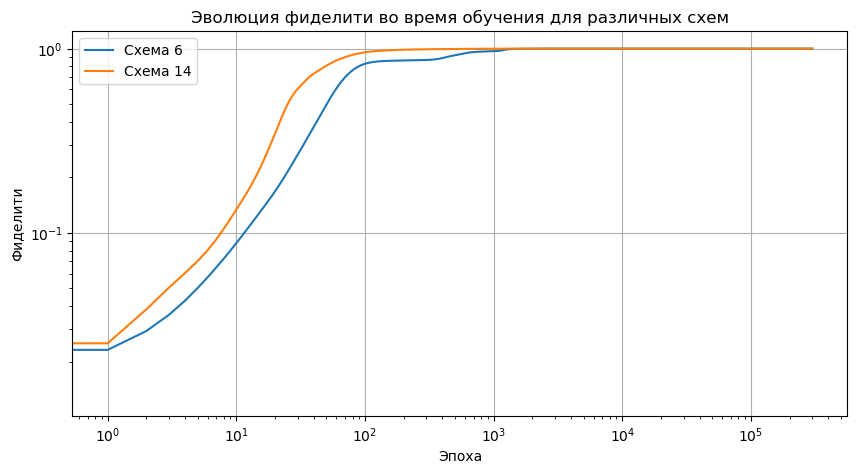

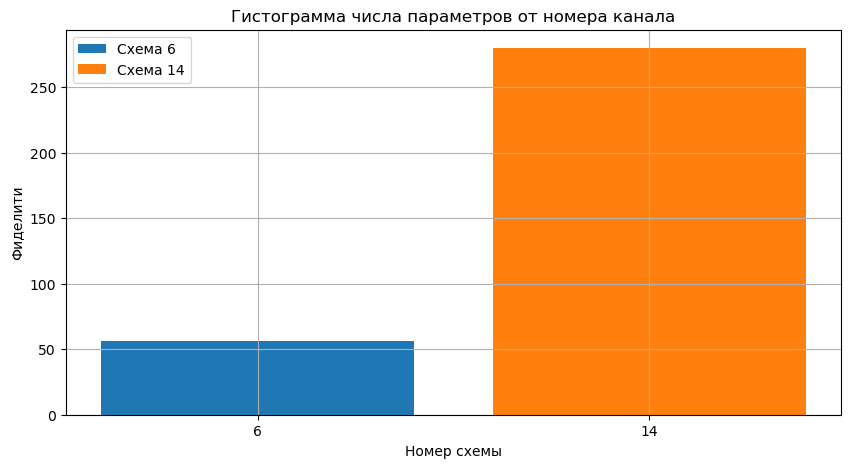

In [74]:
plot_all_fidelities(fid_circ)
plot_bar_num_of_pars(par_circ)

In [80]:
PATH = './models_par/'
torch.save(par_circ['14'], PATH + 'model_circuit_14(bob)')
par_circ['14']

Parameter containing:
tensor([ 1.0336e-01,  1.1265e+00,  1.0984e+00, -2.6274e+00, -1.4961e+00,
        -1.3237e-01,  1.1326e-02, -1.8382e+00, -3.6210e+00, -2.0655e+00,
         4.1455e+00, -1.8618e+00, -1.0861e+00, -7.1061e-01, -2.7887e+00,
         1.0938e+00,  1.2665e+00,  1.3463e+00, -2.6487e+00, -1.5302e-02,
         2.2724e+00,  1.2049e+00, -9.0845e-01,  9.1215e-01,  2.7186e+00,
        -2.0487e+00,  1.0039e+00, -2.5250e+00, -7.9307e-01,  6.9534e-01,
        -2.0397e+00,  9.6316e-01,  2.5458e+00, -2.2828e+00,  1.6637e-01,
         1.5886e+00,  1.9130e+00, -1.8235e-01, -2.7978e-01, -1.2988e+00,
        -3.1816e+00, -4.1293e-02, -2.6083e+00, -7.0926e-03,  1.2923e+00,
         4.5958e-02, -2.0033e+00, -1.3955e+00,  1.1473e+00,  3.0429e+00,
        -3.4663e+00, -1.4322e-01,  1.1678e+00,  2.3525e+00, -7.4090e-01,
         8.4121e-01,  5.8448e-01, -3.0392e+00,  3.4761e+00, -2.7946e+00,
        -1.8806e+00,  2.7443e+00, -2.5142e+00, -6.2540e-01, -1.6877e+00,
        -1.7281e+00,  1.3101e

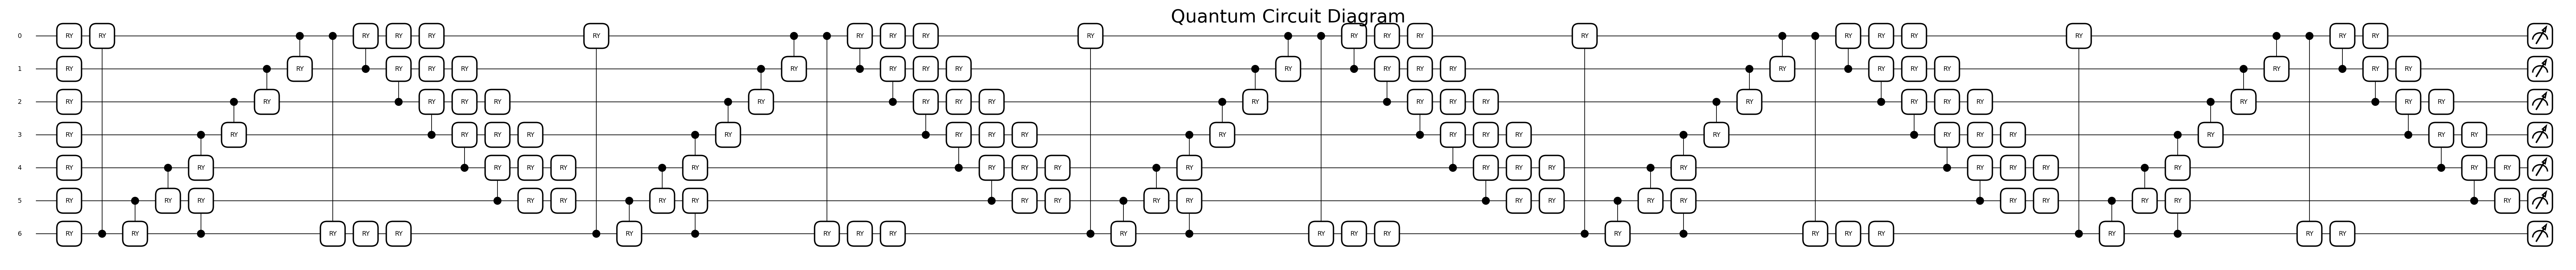

In [87]:
print_circuit(circuit14, par_circ['14'], n_layers = n_layers*5)